# H0 and H1 filter design for adc_receiver_V0

From https://www.dsprelated.com/showcode/270.php

In [1]:
import numpy as np
import scipy
import scipy.signal
import matplotlib.pyplot as plt
#%matplotlib widget

In [2]:
# ~~[Filter Design with Parks-McClellan Remez]~~
N = 30  # Filter order
# Filter symetric around 0.25 (where .5 is pi or Fs/2)
bands = np.array([0., .22, .28, .5])
hr = scipy.signal.remez(N+1, bands, [1,0], [1,1])
hr[abs(hr) <= 1e-4] = 0.
(w,Hr) = scipy.signal.freqz(hr)

# ~~[Filter Design with Windowed freq]~~
hw = scipy.signal.firwin(N+1, 0.5)
hw[abs(hw) <= 1e-4] = 0.
(w, Hw) = scipy.signal.freqz(hw)

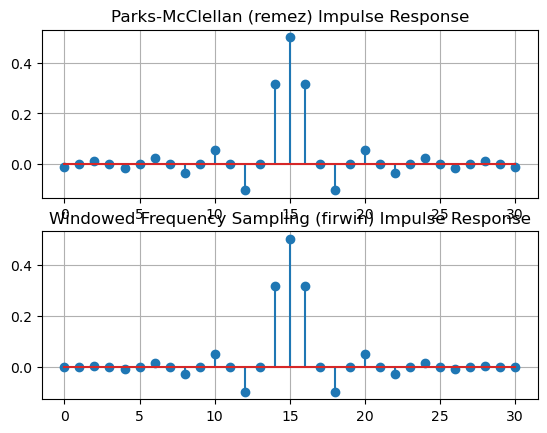

In [3]:

fig = plt.figure()
ax0 = fig.add_subplot(211)
ax0.stem(np.arange(len(hr)), hr)
ax0.grid(True)
ax0.set_title('Parks-McClellan (remez) Impulse Response')
ax1 = fig.add_subplot(212)
ax1.stem(np.arange(len(hw)), hw)
ax1.set_title('Windowed Frequency Sampling (firwin) Impulse Response')
ax1.grid(True)
fig.savefig('hb_imp.png')

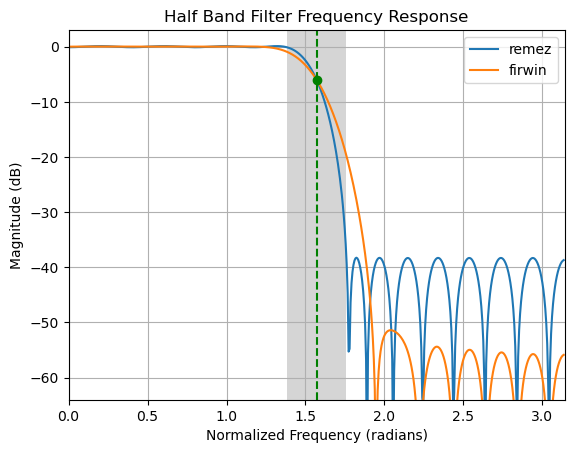

In [4]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(w, 20*np.log10(abs(Hr)))
ax1.plot(w, 20*np.log10(abs(Hw)))
ax1.legend(['remez', 'firwin'])
bx = bands*2*np.pi
ax1.axvspan(bx[1], bx[2], facecolor='0.5', alpha=0.33)
ax1.plot(np.pi/2, -6, 'go')
ax1.axvline(np.pi/2, color='g', linestyle='--')
ax1.axis([0,np.pi,-64,3])
ax1.grid('on')
ax1.set_ylabel('Magnitude (dB)')
ax1.set_xlabel('Normalized Frequency (radians)')
ax1.set_title('Half Band Filter Frequency Response')
fig.savefig('hb_rsp.png')

In [5]:
ax1.axis([0,np.pi*0.5,-0.2,0.2])
fig.savefig('hb_rsp_zoom.png')

## Parallel implementation of HB filter

In [6]:
h = hw

N = 512*64
n = np.arange(N)
x = np.random.randn(*n.shape)
for fc in (0.1, 0.4):
    x += 100 * np.sin(2*np.pi*fc*n)

f, t, Sxx = scipy.signal.stft(x, 1, return_onesided=False, nperseg=512, window='blackman')
f = scipy.fft.fftshift(f)
Sxx = scipy.fft.fftshift(Sxx, axes=0)

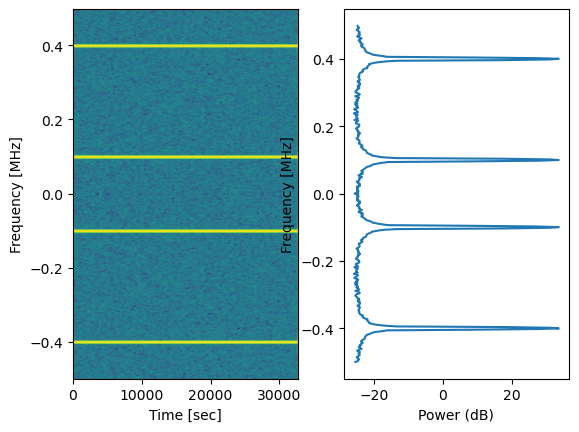

In [7]:
fig, axs = plt.subplots(nrows=1, ncols=2)
axs[0].pcolormesh(t, f, 20*np.log10(np.abs(Sxx)), shading='gouraud')
axs[0].set_ylabel('Frequency [MHz]')
axs[0].set_xlabel('Time [sec]')

Sxx_av = abs(Sxx).mean(axis=1)
axs[1].plot(20*np.log10(Sxx_av), f)
axs[1].set_ylabel('Frequency [MHz]')
axs[1].set_xlabel('Power (dB)')

plt.show()


### Naïve approch: convolve by h and decimate

In [8]:
y = scipy.signal.lfilter(h, 1, x, axis=-1, zi=None)

f, t, Syy = scipy.signal.stft(y, 1, return_onesided=False, nperseg=512, window='blackman')
f = scipy.fft.fftshift(f)
Syy = scipy.fft.fftshift(Syy, axes=0)

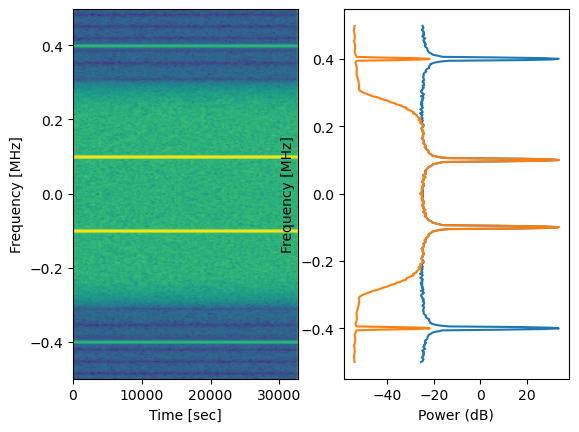

In [9]:
fig, axs = plt.subplots(nrows=1, ncols=2)
axs[0].pcolormesh(t, f, 20*np.log10(np.abs(Syy)), shading='gouraud')
axs[0].set_ylabel('Frequency [MHz]')
axs[0].set_xlabel('Time [sec]')

Syy_av = abs(Syy).mean(axis=1)
axs[1].plot(20*np.log10(Sxx_av), f)
axs[1].plot(20*np.log10(Syy_av), f)
axs[1].set_ylabel('Frequency [MHz]')
axs[1].set_xlabel('Power (dB)')

plt.show()

In [10]:
y_dec = y[0::2]
f_dec, t_dec, Syy_dec = scipy.signal.stft(y_dec, 1/2, return_onesided=False, nperseg=512, window='blackman')
f_dec = scipy.fft.fftshift(f_dec)
Syy_dec = scipy.fft.fftshift(Syy_dec, axes=0)


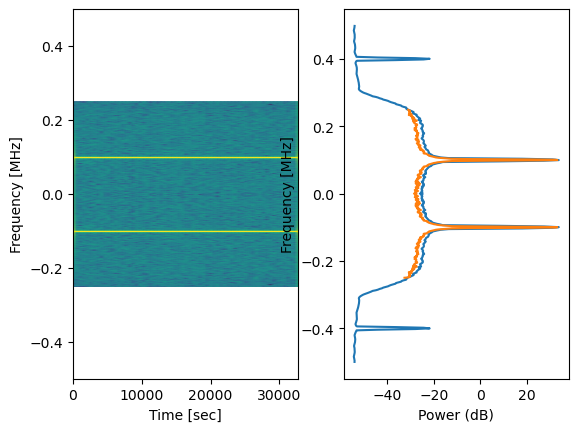

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=2)
axs[0].pcolormesh(t_dec, f_dec, 20*np.log10(np.abs(Syy_dec)), shading='gouraud')
axs[0].set_ylabel('Frequency [MHz]')
axs[0].set_xlabel('Time [sec]')
axs[0].set_ylim((-0.5, 0.5))

Syy_dec_av = abs(Syy_dec).mean(axis=1)
axs[1].plot(20*np.log10(Syy_av), f)
axs[1].plot(20*np.log10(Syy_dec_av), f_dec)
axs[1].set_ylabel('Frequency [MHz]')
axs[1].set_xlabel('Power (dB)')

plt.show()

### Optimisation: polyphase implementation with 2 branches

In [12]:
h_even = h[0::2]
h_odd  = h[1::2]
print(h_even)
print(h_odd )

[-0.0017004   0.00293733 -0.00673009  0.01409389 -0.02678504  0.04909896
 -0.09693833  0.31561956  0.31561956 -0.09693833  0.04909896 -0.02678504
  0.01409389 -0.00673009  0.00293733 -0.0017004 ]
[0.         0.         0.         0.         0.         0.
 0.         0.50080823 0.         0.         0.         0.
 0.         0.         0.        ]


In [13]:
x_even = x[0::2]
x_odd  = x[1::2]
y_even = scipy.signal.lfilter(h_even, 1, x_even, axis=-1, zi=None)
y_odd  = scipy.signal.lfilter(h_odd , 1, x_odd , axis=-1, zi=None)
y_opt = y_even + y_odd

f_opt, t_opt, Syy_opt = scipy.signal.stft(y_opt, 1/2, return_onesided=False, nperseg=512, window='blackman')
f_opt = scipy.fft.fftshift(f_opt)
Syy_opt = scipy.fft.fftshift(Syy_opt, axes=0)


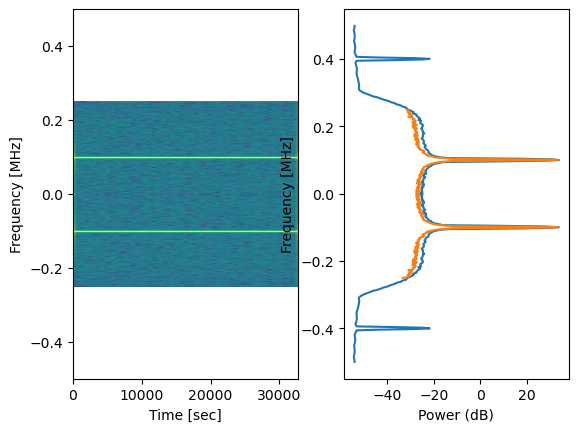

In [14]:
fig, axs = plt.subplots(nrows=1, ncols=2)
axs[0].pcolormesh(t_opt, f_opt, 20*np.log10(np.abs(Syy_opt)), shading='gouraud')
axs[0].set_ylabel('Frequency [MHz]')
axs[0].set_xlabel('Time [sec]')
axs[0].set_ylim((-0.5, 0.5))

Syy_opt_av = abs(Syy_opt).mean(axis=1)
axs[1].plot(20*np.log10(Syy_av), f)
axs[1].plot(20*np.log10(Syy_opt_av), f_dec)
axs[1].set_ylabel('Frequency [MHz]')
axs[1].set_xlabel('Power (dB)')

plt.show()

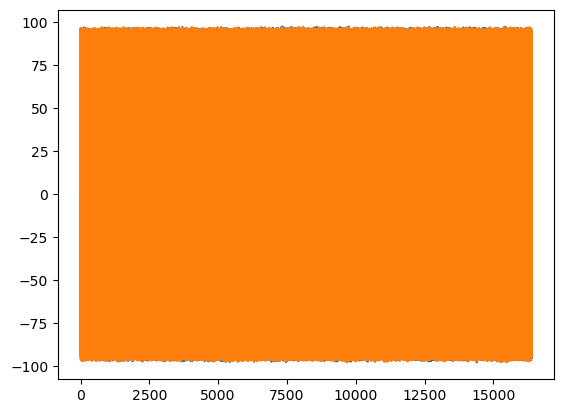

In [15]:
fig, ax = plt.subplots()
ax.plot(y_dec[1:])
ax.plot(y_opt)


In [16]:
h=np.array([-0.0017004, 0.0, 0.00293733, 0.0, -0.00673009, 0.0, 0.01409389,  0.0,-0.02678504,  0.0,   0.04909896,  0.0,-0.09693833,  0.0, 0.31561956, 0.50080823, 0.31561956, 0.0,-0.09693833, 0.0, 0.04909896, 0.0,-0.02678504, 0.0, 0.01409389, 0.0,-0.00673009, 0.0, 0.00293733, 0.0, -0.0017004 ])
h[h>0.5] = 1
h[h<0.5] = 0
h


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [17]:
1/0.50080823


1.9967722974520608